In [118]:
import numpy as np
import numpy.typing as npt
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

TOTAL = 'Monthly Mean Total Sunspot Number'
DIFF = 'Sunspot Diff'

N_STEPS_IN = 100
N_STEPS_OUT = 200
TEST_FRAC = 0.1

In [119]:
df = pd.read_csv("../../datasets/Sunspots.csv")

df.drop(df.columns[0], axis=1, inplace=True)    # Drop index collumn
df['Date'] = pd.to_datetime(df['Date'])         # Always format the date
df = df.sort_values(['Date'])                   # Sort by date

df.head()

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3265 entries, 0 to 3264
Data columns (total 2 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Date                               3265 non-null   datetime64[ns]
 1   Monthly Mean Total Sunspot Number  3265 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 76.5 KB


In [121]:
# https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):

    x, y = list(), list()
    for i in range(len(sequence)):

        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        x.append(seq_x)
        y.append(seq_y)

    return np.array(x), np.array(y)

In [122]:
sunspots_total = df[TOTAL]

all_obs = sunspots_total.shape[0]
test_obs = int(np.round(TEST_FRAC * all_obs))

train_x, train_y = split_sequence(
    sequence=np.array(sunspots_total)[:-(test_obs - N_STEPS_IN)],
    n_steps_in=N_STEPS_IN,
    n_steps_out=N_STEPS_OUT
)
display(train_x.shape, train_y.shape)

train_obs = train_x.shape[0]

(2740, 100)

(2740, 200)

In [166]:
sunspots_total

0        96.7
1       104.3
2       116.7
3        92.8
4       141.7
        ...  
3260      0.6
3261     14.4
3262     34.0
3263     21.8
3264     10.4
Name: Monthly Mean Total Sunspot Number, Length: 3265, dtype: float64

In [123]:
print(f"Train observations: {train_obs}")
print(f"Test observations:  {test_obs}")
print(f"Sum:                {train_obs + test_obs}")
print(f"\nAll observations:   {all_obs}")
print(f"Train + Test == All: {train_obs + test_obs == all_obs + 1 - N_STEPS_OUT}")

Train observations: 2740
Test observations:  326
Sum:                3066

All observations:   3265
Train + Test == All: True


## Regression with XGBoost

In [124]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(train_x, train_y)
xgb_reg.save_model("saved/window_model.json")

### Forecast

`window`, is an ndarrray $1\times \text{N\_STEPS\_IN}$. We make a prediction based on `window` (single example -> single prediction), then move the `window` right, so that it now contains the prediction. Lastly, we save the prediction to the `predictions` 1D array

In [125]:
def ar_forecast(init_window: npt.NDArray[np.float64], pretrained_model: xgb.XGBRegressor) -> npt.NDArray[np.float64]:

    predictions = np.array([])
    for _ in range(test_obs):
        
        prediction = np.expand_dims(pretrained_model.predict(init_window), axis=0)
        init_window = np.concatenate((init_window[:, 1:],  prediction), axis=1)
        predictions = np.append(predictions, prediction[0, 0])
    
    return predictions

def window_forecast(past_data: npt.NDArray[np.float64], pretrained_model: xgb.XGBRegressor) -> npt.NDArray[np.float64]:

    return np.squeeze(pretrained_model.predict(np.reshape(past_data, (1, -1))))

In [157]:
test_x = sunspots_total[train_obs - 1 + 100:].values

In [162]:
if N_STEPS_OUT == 1:
    init_window = np.expand_dims(train_x[-1], axis=0)
    forecast = ar_forecast(init_window, xgb_reg)
else:
    forecast = window_forecast(test_x[:100], xgb_reg)

### Plot predictions

In [127]:
pred_star_idx = train_obs + N_STEPS_IN - 1
pred_end_idx = pred_star_idx + test_obs

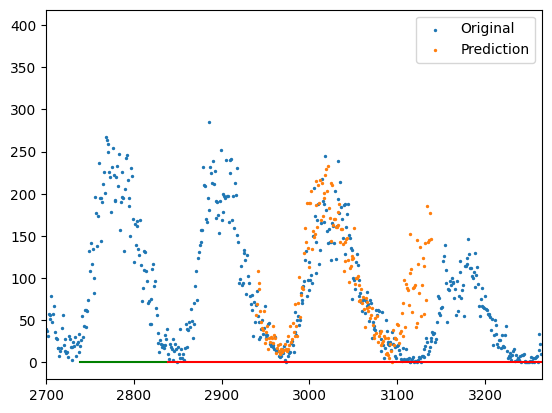

In [165]:
plt.scatter(range(sunspots_total.shape[0]), sunspots_total, color = 'tab:blue', label = 'Original', s=2)
# plt.scatter(range(pred_star_idx, pred_star_idx + forecast.shape[0]), forecast, color='tab:orange', label='Prediction', s=2)
plt.scatter(range(
    train_obs - 1 + 100 + 100,
    train_obs - 1 + 100 + 100 + 200
), forecast, color='tab:orange', label='Prediction', s=2)
plt.plot(range(train_obs - 1, train_obs - 1 + 100), np.zeros(100), color="green")
plt.plot(range(train_obs - 1 + 100, train_obs - 1 + 100 + test_x.shape[0]), np.zeros(test_x.shape[0]), color="red")
plt.xlim(pred_star_idx - 75, all_obs)
plt.xlim(2700, all_obs)
plt.legend()
plt.show()